In [1]:
import sys
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.io import mmread
from scipy.io import mmwrite
from scipy.sparse import csr_matrix


In [2]:
# solve the jax and jaxlib issue from https://github.com/google/jax/issues/5501
import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns


Global seed set to 0


In [3]:
results_folder = '../results/visium_axolotl_R12830_resequenced_20220308/cell2location_coarse_out'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'


In [4]:
original_counts = np.round(csr_matrix(mmread("../data/snRNAseq_countMatrix.mtx")))


In [7]:
original_counts

<38280x30419 sparse matrix of type '<class 'numpy.float64'>'
	with 129932604 stored elements in Compressed Sparse Row format>

In [9]:
original_meta = pd.read_csv("../data/snRNAseq_countMatrix_metadata.csv", index_col = 0)
original_meta

/var/folders/ld/7f_9j5n17vs69r90p179ws240000gp/T/ipykernel_18500/1930074783.py:1: DtypeWarning: Columns (12,14,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  original_meta = pd.read_csv("../data/snRNAseq_countMatrix_metadata.csv", index_col = 0)


,orig.ident,nCount_RNA,nFeature_RNA,iscell_dd,iscell_ed,condition,percent.mt,RNA_snn_res.0.7,seurat_clusters,RNA_snn_res.0.5,...,pANN_0.25_0.01_606,DF.classifications_0.25_0.01_606,pANN_0.25_0.005_511,DF.classifications_0.25_0.005_511,pANN_0.25_0.005_610,DF.classifications_0.25_0.005_610,pANN_0.25_0.005_543,DF.classifications_0.25_0.005_543,subtypes,celltypes
AAACAGCCAAGGTACG-1_1_1,SeuratProject,7112.00099,3562,True,NaN,Amex_scRNA_d0,4.836895,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Proliferating_ECs,EC
AAACAGCCACTTCATC-1_1_1,SeuratProject,4545.99957,2508,True,NaN,Amex_scRNA_d0,4.839411,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EC,EC
AAACAGCCAGCACGAA-1_1_1,SeuratProject,4228.99995,2315,True,NaN,Amex_scRNA_d0,8.252542,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EC,EC
AAACATGCAACAACAA-1_1_1,SeuratProject,6723.00029,3208,True,NaN,Amex_scRNA_d0,3.703711,6,6,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NPPA+_CMs,CM
AAACATGCAAGGTGGC-1_1_1,SeuratProject,6230.00127,2793,True,NaN,Amex_scRNA_d0,7.078656,3,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EC,EC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTCTAACCT-1,SeuratProject,5594.99981,2835,True,NaN,Amex_scRNA_d14,5.826624,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.019231,Singlet,EC,EC
TTTGTTGGTCTAGCTT-1,SeuratProject,11179.99966,4659,True,NaN,Amex_scRNA_d14,1.923077,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.096154,Singlet,CMs_(ROBO2+),CM
TTTGTTGGTGGTTCCC-1,SeuratProject,5147.99951,2302,True,NaN,Amex_scRNA_d14,8.508159,14,14,8,...,NaN,NaN,NaN,NaN,NaN,NaN,0.153846,Singlet,RBC,RBC
TTTGTTGGTGTGCAAC-1,SeuratProject,5443.00088,2615,True,NaN,Amex_scRNA_d14,9.369836,4,4,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,Singlet,Injury_specific_EC,EC


In [10]:
original_genes = pd.read_csv("../data/snRNAseq_countMatrix_gene.csv", index_col = 0)
original_genes

""
x
ZNF268-AMEX60DD000002
ZNF850-AMEX60DD000003
ZNF268-AMEX60DD000004
AMEX60DD000005
ZNF268-AMEX60DD000006
...
AMEX60DDU001023233
AMEX60DDU001025702
AMEX60DDU001029469


In [11]:
adata_ref = ad.AnnData(original_counts, obs=original_meta, var = original_genes)

/var/folders/ld/7f_9j5n17vs69r90p179ws240000gp/T/ipykernel_18500/1072320767.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_ref = ad.AnnData(original_counts, obs=original_meta, var = original_genes)


In [14]:
adata_ref
adata_ref.to_df() # double check if the cell barcodes and gene names are correct 

x,ZNF268-AMEX60DD000002,ZNF850-AMEX60DD000003,ZNF268-AMEX60DD000004,AMEX60DD000005,ZNF268-AMEX60DD000006,AMEX60DD000008,AMEX60DD000009,AMEX60DD000011,AMEX60DD000013,AMEX60DD000018,...,AMEX60DDU001013717,AMEX60DDU001018501,AMEX60DDU001019043,AMEX60DDU001020705,AMEX60DDU001020730,AMEX60DDU001023233,AMEX60DDU001025702,AMEX60DDU001029469,AMEX60DDU001037636,AMEX60DDU001039027
AAACAGCCAAGGTACG-1_1_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAGCCACTTCATC-1_1_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAGCCAGCACGAA-1_1_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATGCAACAACAA-1_1_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATGCAAGGTGGC-1_1_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTCTAACCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGGTCTAGCTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGGTGGTTCCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGGTGTGCAAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# filtering 
# pal_data = pal_data[pal_data.obs.cellclusters!="glut_SUBSET_23",]

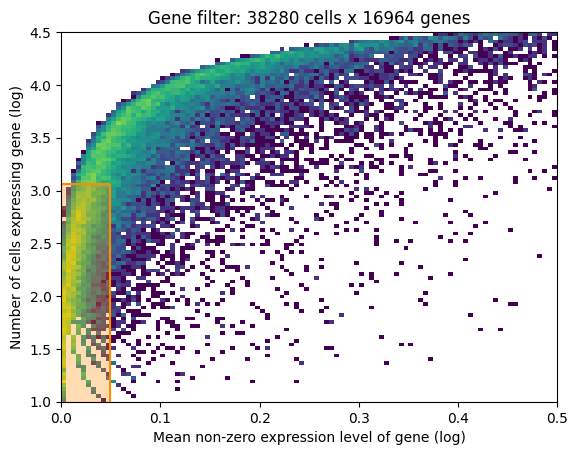

In [16]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()


In [17]:
adata_ref

AnnData object with n_obs × n_vars = 38280 × 16964
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'iscell_dd', 'iscell_ed', 'condition', 'percent.mt', 'RNA_snn_res.0.7', 'seurat_clusters', 'RNA_snn_res.0.5', 'pANN_0.25_0.02_773', 'DF.classifications_0.25_0.02_773', 'pANN_0.25_0.01_606', 'DF.classifications_0.25_0.01_606', 'pANN_0.25_0.005_511', 'DF.classifications_0.25_0.005_511', 'pANN_0.25_0.005_610', 'DF.classifications_0.25_0.005_610', 'pANN_0.25_0.005_543', 'DF.classifications_0.25_0.005_543', 'subtypes', 'celltypes'
    var: 'n_cells', 'nonz_mean'

In [26]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key=None,
                        # cell type, covariate used for constructing signatures
                        labels_key='subtypes',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['condition']
                       )


In [27]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.17.3.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': 'subtypes',
│   'categorical_covariate_keys': ['condition'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│          n_vars          │ 16964 │
│         n_cells          │ 38280 │
│         n_batch          │   1   │
│         n_labels         │  26   │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│         labels         │         adata.obs['_scvi_labels']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                             labels State Registry                              
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃           Categories           ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['subtypes'] │            B_cells             │          0          │
│                       │    CM_(TBX5-,ERBB4+,FGF14+)    │          1          │
│                       │          CMs_(ROBO2+)          │          2          │
│                       │               EC               │          3          │
│                       │           EC_(LHX6+)           │          4          │
│                       │          EC_(VCAM1+)           │          5          │
│                       │           EC_(Wnt4+)           │          6          │
│                       │              FB_1              │          7          │
│                       │              FB_2              │          8          │
│                       │              FB_3              │          9          │
│                       │       Injury_specific_EC       │         10          │
│                       │         Megakeryocytes         │         11          │
│                       │        Mono_Macrophages        │         12          │
│                       │           NPPA+_CMs            │         13          │
│                       │            Neuronal            │         14          │
│                       │           Neutrophil           │         15          │
│                       │     Proliferating_B_cells      │         16          │
│                       │       Proliferating_CMs        │         17          │
│                       │    Proliferating_CMs_NPPA+     │         18          │
│                       │       Proliferating_ECs        │         19          │
│                       │  Proliferating_Megakeryocytes  │         20          │
│                       │ Proliferating_Mono_Macrophages │         21          │
│                       │       Proliferating_RBC        │         22          │
│                       │              RBC               │         23          │
│                       │          Resident_MF           │         24          │
│                       │            T_cells             │         25          │
└───────────────────────┴────────────────────────────────┴─────────────────────┘

              extra_categorical_covs State Registry              
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['condition'] │ Amex_scRNA_d0  │          0          │
│                        │ Amex_scRNA_d1  │          1          │
│                        │ Amex_scRNA_d4  │          2          │
│                        │ Amex_scRNA_d7  │          3          │
│                        │ Amex_scRNA_d14 │          4          │
│                        │                │                     │
└────────────────────────┴────────────────┴─────────────────────┘

In [28]:
# Use all data for training (validation not implemented yet, train_size=1)
# takes ~ 3.5h for 175 epochs, but should increase to 200/250 epochs
mod.train(max_epochs=250, batch_size=2500, train_size=1, lr=0.002, use_gpu=False) 

# plot ELBO loss history during training, removing first 20 epochs from the plot
#mod.plot_history(20)

#mod.train(max_epochs=50, use_gpu=False)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jingkui.wang/anaconda3/envs/cell2loc_3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:131: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")


Epoch 250/250: 100%|█████████| 250/250 [5:10:45<00:00, 74.58s/it, v_num=1, elbo_train=3.75e+8]


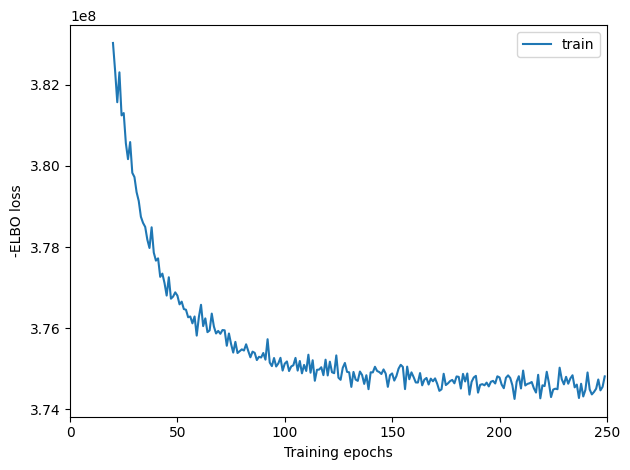

In [29]:
# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)


In [30]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': False}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc_subtypes_v1.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling global variables, sample: 100%|████████████████████| 999/999 [03:32<00:00,  4.69it/s]


'../results/visium_axolotl_R12830_resequenced_20220308/cell2location_coarse_out/reference_signatures/sc_subtypes_v1.h5ad'

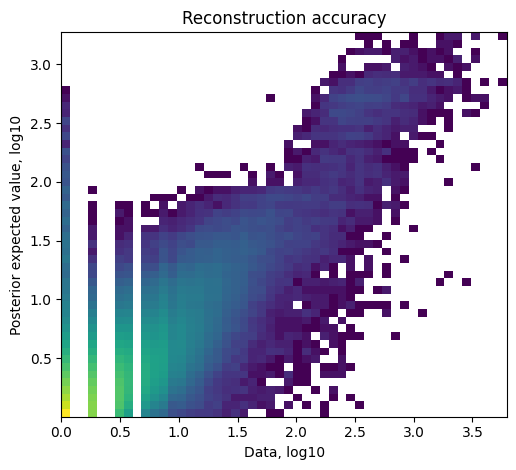

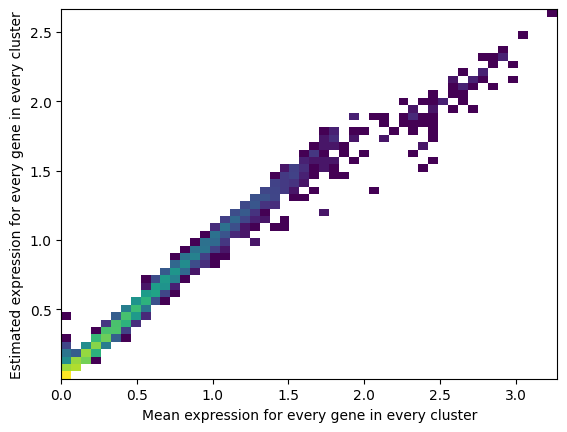

In [31]:
mod.plot_QC()


In [ ]:
# The model and output h5ad can be loaded later like this if needed
ref_run_name = "/Volumes/groups/tanaka/People/current/jiwang/projects/heart_regeneration/results/visium_axolotl_R12830_resequenced_20220308/cell2location_coarse_out/reference_signatures/"

adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)

In [24]:
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File ../results/visium_axolotl_R12830_resequenced_20220308/cell2location_coarse_out/
         reference_signatures/model.pt already downloaded                                    


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jingkui.wang/anaconda3/envs/cell2loc_3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:131: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")


Epoch 1/522:   0%|               | 1/522 [00:04<38:29,  4.43s/it, v_num=1, elbo_train=4.05e+8]


In [25]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,Bcell,CM,EC,FB,Macrophages
x,,,,,
AMEX60DD000005,0.028662,0.033995,0.033599,0.047608,0.026082
GLT1D1-AMEX60DD000031,0.038463,0.042347,0.024647,0.078734,0.258576
GLT1D1-AMEX60DD000033,0.080134,0.061576,0.055839,0.110355,0.412841
SLC15A4-AMEX60DD000036,0.248516,0.328900,0.156976,0.236047,1.758406
TMEM132C-AMEX60DD000038,0.051951,0.543897,0.080506,0.701270,0.120176


In [ ]:
# load visium data 
vis = sc.read_loom("../data/processed/D1_113_sub_b.loom")


In [ ]:
vis.X = np.round(vis.X)